In [128]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import textwrap
from IPython.display import clear_output
import numpy as np
from ipywidgets import Button, HTML, Output
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression


In [47]:
INPUT_PATH = "../../data/lda/df_30topics10passes.csv"
RATER = "Jakob"

In [48]:
# def lda_sample_and_rate():
# """
# For determining thresholds
# Randomly sample items whose probability is within [lower_prob, upper_prob],
# collect manual ratings (1 = belongs, 0 = not).
# Returns a DataFrame with columns ['probability', 'rating'] of length n (or fewer if not enough speeches).
# """

df_topics = pd.read_csv(INPUT_PATH)

In [53]:
topic_id = 19
prob_range = (0.25, 0.45)
n = 100
seed = 42


lower_prob, upper_prob = prob_range
prob_col = f"topic_{topic_id}"
candidates = df_topics[(df_topics[prob_col] >= lower_prob) & (df_topics[prob_col] <= upper_prob)]

sampled = candidates.sample(n=min(n, len(candidates)), random_state=seed).reset_index(drop=True)
ratings = []

print("Sanity check: speech with max topic score\n\t", df_topics[df_topics[prob_col] == (df_topics[prob_col]).max()]["translatedText"].iloc[0])


Sanity check: speech with max topic score
	 I voted in favour of this report. Europe has been paralysed with regard to the migrant crisis. While we keep discussing possible solutions to the grave problem we face, it hardly ever comes to common action. However, even when we do decide on joint measures, we do not follow through on them. The Dublin Agreement and the relocation system have failed utterly, as the Member States have not committed to apply them. We must either effectively enforce the current measures, or introduce new ones. Either way, it is not a problem that can be solved by any Member State alone. It is a dilemma that must be dealt with by the European Union as a whole. It cannot be fixed by closing national borders, but only by guarding our common ones; those defined by Schengen. What we need to do is form a common border guard and coast guard and put a collective reception and relocation system in place. Furthermore, we must prompt Turkey to crack down on the criminals s

In [72]:
def get_rating(sampled, index, prob_col):
    def process_response(prompt= "Rate (y, n, q):"): 
        answer = input(prompt)
        if answer == 'q':
            return -1
        elif answer == 'y': 
            return 1
        elif answer == 'n': 
            return 0
        else: 
            return process_response("Try again (y, n, q):")

    row = sampled.iloc[index]

    print(f"Progress: {index}/{len(sampled)} speeches rated")
    print("\n")
    # print(f"\nSpeech {index}/{len(sampled)} | Year: {row['year']} | Party block: {row['block']}")
    # print(f"Topic probability: {row[prob_col]:.4f}")
    print(textwrap.fill(row["translatedText"], width=90))

    return process_response()

In [ ]:
running = True
if len(ratings) == len(sampled): 
    print("Ratings are done.")
else: 
    print(f"Starting manual rating: {len(ratings)}/{len(sampled)} speeches to rate.")
    print(f"{'='*90}\n")

    out = Output()
    display(out) 
    with out: 
        while running: 
            clear_output()

            current_index = len(ratings)
            response = get_rating(sampled, current_index, prob_col)
            if response == -1: 
                clear_output()
                print("Terminated.")
                print("Continue at index", current_index)
                running = False
            else: 
                ratings.append(response)


            if current_index >= len(sampled)-1:
                print(f"Rating complete! Rated {len(ratings)}/{len(sampled)} speeches.")
                # Now add ratings to dataframe
                sampled.loc[:len(ratings)-1, 'rating'] = ratings
                print(f"\nFinal ratings: {ratings}")
                running = False
print(ratings)


Starting manual rating: 40/100 speeches to rate.



Output()

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1]


In [89]:
ratings

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1]

In [111]:
r_copy = ratings.copy()
# r_copy = [1 - r for r in r_copy]
r_copy.extend(([0] * (len(sampled) - len(r_copy))))

print(len(r_copy))
# sampled[[bool(r) for r in r_copy]][["translatedText", prob_col]]
sampled[[bool(r) for r in r_copy]][prob_col].min()

100


np.float64(0.2542153596878052)

In [101]:
print(ratings)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1]


In [ ]:
sum(ratings)

32

In [ ]:
sum(ratings)

In [ ]:
# only keep relevant columns
df_ratings = sampled.copy()
# if len(ratings) < len(sampled): 
#     print("only rated a subset of sample", len(ratings), "of", len(sampled))
#     df_ratings = df_ratings.iloc[:len(ratings)]

# df_ratings["rating"] = ratings
df_ratings = df_ratings[[f'translatedText', f'topic_{topic_id}', 'rating']]

only rated a subset of sample 40 of 100


In [115]:
# save ratings: 
df_ratings.to_csv(f"tf_idf_ratings_{RATER}.csv")

In [ ]:
# ratings_jakob = pd.read_csv("tf_idf_ratings_Jakob.csv")
# ratings_quirin = pd.read_csv("tf_idf_ratings_Quirin.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'tf_idf_ratings_Quirin.csv'

In [132]:
df_ratings[(df_ratings["rating"] == 1) & (df_ratings[prob_col] < 0.27)]["translatedText"]

11    I voted against this report which was polluted...
12    Madam President, Mr. Vice-President, with what...
20    Russia's military aggression against Ukraine a...
Name: translatedText, dtype: object

In [117]:
ratings_both = [df_ratings]

Average correct topic rate: 0.78
Topic probability threshold for 95.0% accuracy: 8.2041828747833


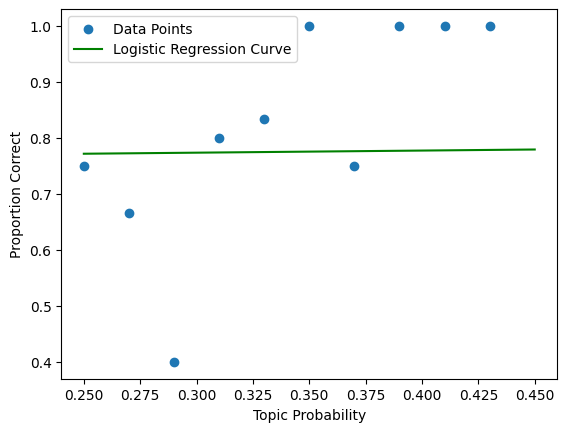

In [131]:
# compare ratings
for df_ratings in ratings_both:
    # print average rejection rate
    avg_correct = df_ratings['rating'].mean()
    print(f"Average correct topic rate: {avg_correct:.2f}")
    # calculate mean ratings for every whole percentage step
    stepsize = 0.02
    percentile_segments = np.arange(prob_range[0], prob_range[1] + 1, stepsize)
    segment_n = len(percentile_segments)
    proportion_correct = []
    for i in range(len(percentile_segments)):
        if i == segment_n-1:
            upper_bound = percentile_segments[-1]
        else:
            lower_bound = percentile_segments[i]
            upper_bound = percentile_segments[i+1]
            segment_ratings = df_ratings[(df_ratings[f'topic_{topic_id}'] >= lower_bound) & (df_ratings[f'topic_{topic_id}'] < upper_bound)]
            if len(segment_ratings) > 0:
                prop_correct = segment_ratings['rating'].mean()
            else:
                prop_correct = np.nan
        proportion_correct.append(prop_correct)

    # fit logistic regression model
    # rating as categorical variable
    df_ratings['rating'] = df_ratings['rating'].astype(int)
    X = np.array(df_ratings[f'topic_{topic_id}']).reshape(-1, 1)
    y = np.array(df_ratings["rating"]).reshape(-1, 1)
    log_model = LogisticRegression()
    log_model.fit(X, y.ravel())
    desired_accuracy = 0.95

    # plot logistic regression curve
    plt.figure()
    plt.scatter(percentile_segments, proportion_correct, label='Data Points')
    # Generate a range of percentiles for smooth curve
    x_range = np.linspace(prob_range[0], prob_range[1], 300).reshape(-1, 1)
    # Predict probabilities using the logistic model
    y_prob = log_model.predict_proba(x_range)[:, 1]
    plt.plot(x_range, y_prob, color='green', label='Logistic Regression Curve')

    # Calculate the percentile threshold for the desired accuracy
    logit_threshold = np.log(desired_accuracy / (1 - desired_accuracy))
    coef = log_model.coef_[0][0]
    intercept = log_model.intercept_[0]
    percentile_threshold = (logit_threshold - intercept) / coef
    print(f"Topic probability threshold for {desired_accuracy*100}% accuracy: {percentile_threshold}")

    # plt.axhline(desired_accuracy, linestyle="--")
    # plt.axvline(percentile_threshold, linestyle="-", c="red")
    plt.xlabel('Topic Probability')
    plt.ylabel('Proportion Correct')
    plt.legend()
    plt.show()



In [ ]:
# combine ratings
ratings_combined = pd.concat(ratings_both, ignore_index=True)
desired_accuracy = 0.95